# Exploration

In [1]:

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [2]:

import sys
import random
import warnings


from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

C:\Users\alexis.rougecarrassa\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tqdm import tqdm_notebook as tqdm

In [4]:
import os
os.getcwd()

'C:\\Users\\alexis.rougecarrassa\\Documents\\GitHub\\tgs-salt-identification\\tgs_data'

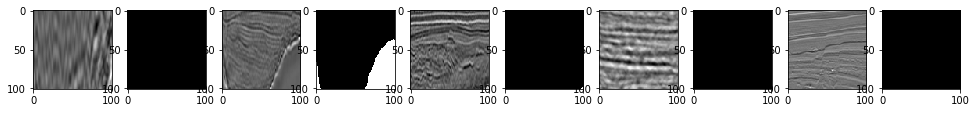

In [5]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = tf.keras.preprocessing.image.load_img(os.getcwd()+'/train/images/' + img_name + '.png')
    img_mask = tf.keras.preprocessing.image.load_img(os.getcwd()+'/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [6]:
train_ids = next(os.walk(os.getcwd()+"/train/images"))[2]
test_ids = next(os.walk(os.getcwd()+"/test/images"))[2]

In [7]:
print(next(os.walk(os.getcwd()+"/train/images")))

('C:\\Users\\alexis.rougecarrassa\\Documents\\GitHub\\tgs-salt-identification\\tgs_data/train/images', [], ['000e218f21.png', '003c477d7c.png', '00441f1cf2.png', '0050766ae2.png', '005b452274.png', '0061281eea.png', '008a50a2ec.png', '00950d1627.png', '00a3af90ab.png', '00cda0328c.png', '0108518d1e.png', '010ee525b6.png', '0115703825.png', '01323211a0.png', '016fc8031c.png', '019afb4b4e.png', '01b5362cce.png', '01c033e116.png', '01c2045d03.png', '020376e68e.png', '020678ec1b.png', '02117a400e.png', '021494f3aa.png', '02206b234e.png', '022b1b01be.png', '023d486fba.png', '0243477802.png', '0249c49180.png', '026b509cd4.png', '026f97575b.png', '0280db420c.png', '0280deb8ae.png', '029c321179.png', '02adf272e9.png', '02d40993ab.png', '03049b14ca.png', '0304e9ac37.png', '03511989ac.png', '0389fc6012.png', '03a9a9f615.png', '03be56aa9a.png', '03c9b5ffe8.png', '03eed26d3e.png', '0401ae15d3.png', '04182ced8e.png', '041925f04c.png', '04234be388.png', '0429d9759b.png', '042c3d4e03.png', '04315b9a6

In [8]:
X_train = np.zeros((len(train_ids),128,128,3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids),128,128, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.getcwd()+"/train"
    img = tf.keras.preprocessing.image.load_img(path + '/images/' + id_)
    x = tf.keras.preprocessing.image.img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 



Done!


In [23]:
np.dstack((X_train[ix],X_train[ix],X_train[ix]))

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [ 71,  71,  71, ...,  71,  71,  71],
        [ 63,  63,  63, ...,  63,  63,  63],
        ...,
        [ 77,  77,  77, ...,  77,  77,  77],
        [ 78,  78,  78, ...,  78,  78,  78],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [105, 105, 105, ..., 105, 105, 105],
        [ 95,  95,  95, ...,  95,  95,  95],
        ...,
        [ 59,  59,  59, ...,  59,  59,  59],
        [ 64,  64,  64, ...,  64,  64,  64],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [106, 106, 106, ..., 106, 106, 106],
        [105, 105, 105, ..., 105, 105, 105

In [28]:
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

In [32]:
Z

array([[ 3.04599342e-08,  3.53672816e-08,  4.10139437e-08, ...,
         4.19694495e-08,  3.59915557e-08,  3.08143049e-08],
       [ 3.53672816e-08,  4.10652432e-08,  4.76216291e-08, ...,
         4.84016714e-08,  4.14911034e-08,  3.55076995e-08],
       [ 4.10139437e-08,  4.76216291e-08,  5.52247930e-08, ...,
         5.57277946e-08,  4.77509785e-08,  4.08463455e-08],
       ...,
       [ 4.19694495e-08,  4.84016714e-08,  5.57277946e-08, ...,
        -1.20875533e-03, -1.09715357e-03, -9.94611576e-04],
       [ 3.59915557e-08,  4.14911034e-08,  4.77509785e-08, ...,
        -1.09715357e-03, -9.95855618e-04, -9.02780992e-04],
       [ 3.08143049e-08,  3.55076995e-08,  4.08463455e-08, ...,
        -9.94611576e-04, -9.02780992e-04, -8.18405195e-04]])

In [31]:
np.dstack((X_train[ix],X_train[ix],X_train[ix]))

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [173, 173, 173, ..., 173, 173, 173],
        [177, 177, 177, ..., 177, 177, 177],
        ...,
        [ 12,  12,  12, ...,  12,  12,  12],
        [ 10,  10,  10, ...,  10,  10,  10],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [150, 150, 150, ..., 150, 150, 150],
        [156, 156, 156, ..., 156, 156, 156],
        ...,
        [ 15,  15,  15, ...,  15,  15,  15],
        [  9,   9,   9, ...,   9,   9,   9],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [ 95,  95,  95, ...,  95,  95,  95],
        [ 90,  90,  90, ...,  90,  90,  90

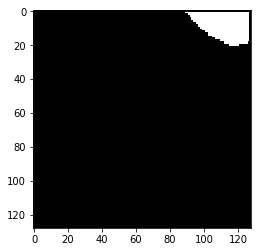

In [33]:
# Check if training data looks all right
#ix = random.randint(0, len(train_ids))

ix=1

#plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
# checks : Z1 = np.exp(-X**2 - Y**2)
# Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
# Z = (Z1 - Z2) * 2
#plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [21]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [22]:
# Build U-Net model
inputs = Input((128, 128, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [24]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30


1472/3600 [===========>..................] - ETA: 19:35 - loss: 0.6935 - mean_iou: 0.0000e+0 - ETA: 12:27 - loss: 0.6932 - mean_iou: 0.1531    - ETA: 10:55 - loss: 0.6931 - mean_iou: 0.228 - ETA: 10:21 - loss: 0.6932 - mean_iou: 0.261 - ETA: 9:58 - loss: 0.6930 - mean_iou: 0.270 - ETA: 9:26 - loss: 0.6928 - mean_iou: 0.28 - ETA: 8:51 - loss: 0.6925 - mean_iou: 0.28 - ETA: 8:28 - loss: 0.6925 - mean_iou: 0.29 - ETA: 8:08 - loss: 0.6920 - mean_iou: 0.29 - ETA: 7:49 - loss: 0.6917 - mean_iou: 0.30 - ETA: 7:34 - loss: 0.6914 - mean_iou: 0.30 - ETA: 7:22 - loss: 0.6910 - mean_iou: 0.31 - ETA: 7:11 - loss: 0.6912 - mean_iou: 0.31 - ETA: 7:01 - loss: 0.6909 - mean_iou: 0.31 - ETA: 6:52 - loss: 0.6903 - mean_iou: 0.32 - ETA: 6:45 - loss: 0.6901 - mean_iou: 0.32 - ETA: 6:39 - loss: 0.6885 - mean_iou: 0.32 - ETA: 6:33 - loss: 0.6877 - mean_iou: 0.32 - ETA: 6:28 - loss: 0.6856 - mean_iou: 0.32 - ETA: 6:24 - loss: 0.6826 - mean_iou: 0.33 - ETA: 6:20 - loss: 0.6750 - mean_iou: 0.33 - ETA: 6:16 - lo

1488/3600 [===========>..................] - ETA: 6:13 - loss: 0.3863 - mean_iou: 0.37 - ETA: 6:20 - loss: 0.4275 - mean_iou: 0.37 - ETA: 6:15 - loss: 0.4522 - mean_iou: 0.37 - ETA: 6:09 - loss: 0.4580 - mean_iou: 0.37 - ETA: 6:01 - loss: 0.4244 - mean_iou: 0.37 - ETA: 6:04 - loss: 0.3800 - mean_iou: 0.37 - ETA: 6:00 - loss: 0.3599 - mean_iou: 0.37 - ETA: 5:54 - loss: 0.3648 - mean_iou: 0.37 - ETA: 5:57 - loss: 0.4376 - mean_iou: 0.37 - ETA: 6:04 - loss: 0.4563 - mean_iou: 0.37 - ETA: 6:02 - loss: 0.4834 - mean_iou: 0.37 - ETA: 6:06 - loss: 0.4809 - mean_iou: 0.37 - ETA: 6:10 - loss: 0.4885 - mean_iou: 0.37 - ETA: 6:12 - loss: 0.4857 - mean_iou: 0.37 - ETA: 6:12 - loss: 0.4929 - mean_iou: 0.37 - ETA: 6:09 - loss: 0.4997 - mean_iou: 0.37 - ETA: 6:06 - loss: 0.4984 - mean_iou: 0.37 - ETA: 6:06 - loss: 0.5032 - mean_iou: 0.37 - ETA: 6:03 - loss: 0.5094 - mean_iou: 0.37 - ETA: 6:00 - loss: 0.5209 - mean_iou: 0.37 - ETA: 5:57 - loss: 0.5217 - mean_iou: 0.37 - ETA: 5:54 - loss: 0.5250 - mean

KeyboardInterrupt: 